## Load TSML filters

In [24]:
using TSML
using TSML.Utils
using TSML.TSMLTypes
using TSML.TSMLTransformers

using TSML: CSVDateValReader, CSVDateValWriter, Statifier
using TSML: Monotonicer, Outliernicer, Plotter

## Create artificial data function

In [25]:
using DataFrames
using Dates
using Random

ENV["COLUMNS"]=1000 # for dataframe column size

function generateXY()
    Random.seed!(123)
    gdate = DateTime(2014,1,1):Dates.Minute(15):DateTime(2014,1,5)
    gval = Array{Union{Missing,Float64}}(rand(length(gdate)))
    gmissing = floor(0.30*length(gdate)) |> Integer
    gndxmissing = Random.shuffle(1:length(gdate))[1:gmissing]
    X = DataFrame(Date=gdate,Value=gval)
    X[:Value][gndxmissing] .= missing
    Y = rand(length(gdate))
    (X,Y)
end;

## Generate artificial data with missing

In [26]:
(df,outY)=generateXY()
first(df,10)

,Date,Value
,DateTime,Float64⍰
1,2014-01-01T00:00:00,0.768448
2,2014-01-01T00:15:00,0.940515
3,2014-01-01T00:30:00,0.673959
4,2014-01-01T00:45:00,0.395453
5,2014-01-01T01:00:00,missing
6,2014-01-01T01:15:00,0.662555
7,2014-01-01T01:30:00,0.586022
8,2014-01-01T01:45:00,missing
9,2014-01-01T02:00:00,0.26864


## User Pipeline and Plotter to plot artificial data

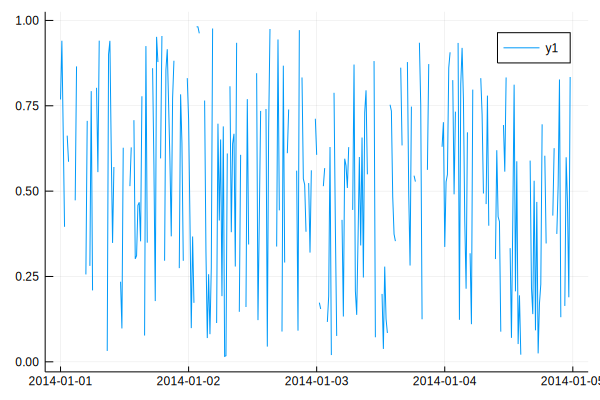

In [27]:
pltr=Plotter(Dict(:interactive => false))

mypipeline = Pipeline(Dict(
  :transformers => [pltr]
 )
)

fit!(mypipeline, df)
transform!(mypipeline, df)

## Get statistics including blocks of missing data

In [28]:
statfier = Statifier(Dict(:processmissing=>true))

mypipeline = Pipeline(Dict(
  :transformers => [statfier]
 )
)

fit!(mypipeline, df)
res = transform!(mypipeline, df)

,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf,bmedian,bmean,bq25,bq75,bmin,bmax
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2014-01-05T00:00:00,0.249351,270,0.995414,0.000412399,0.521184,0.505873,0.121582,0.213152,0.279623,0.745784,0.781425,0.870951,-1.14079,-0.065312,0.546211,69.5203,0.320605,0.312706,1.0,1.32184,1.0,2.0,1.0,3.0


## Use Pipeline: aggregate, impute, and plot 

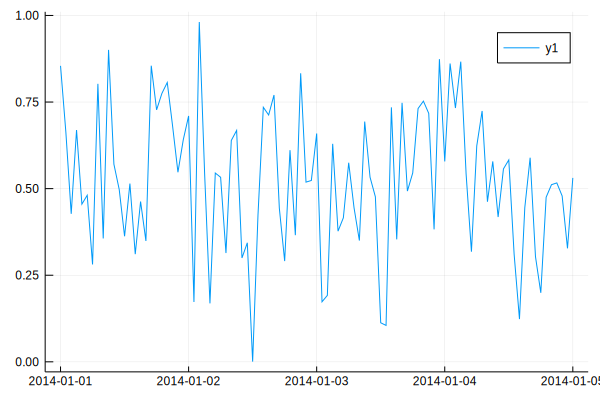

In [29]:
valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))

mypipeline = Pipeline(Dict(
  :transformers => [valgator,pltr]
 )
)

fit!(mypipeline, df)
transform!(mypipeline, df)

## Try real data

In [30]:
fname = joinpath(dirname(pathof(TSML)),"../data/testdata.csv")
csvreader = CSVDateValReader(Dict(:filename=>fname,:dateformat=>"dd/mm/yyyy HH:MM"))

outputname = joinpath(dirname(pathof(TSML)),"/tmp/testdata_output.csv")
csvwriter = CSVDateValWriter(Dict(:filename=>outputname))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
outliernicer = Outliernicer(Dict(:dateinterval=>Dates.Hour(1)));

## Plot real data with missing values

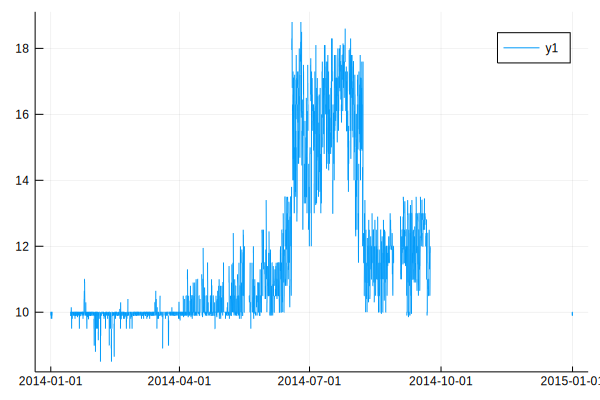

In [31]:
mpipeline1 = Pipeline(Dict(
  :transformers => [csvreader,valgator,pltr]
 )
)

fit!(mpipeline1)
transform!(mpipeline1)

## Get statistics including blocks of missing data

In [32]:
mpipeline1 = Pipeline(Dict(
  :transformers => [csvreader,valgator,stfier]
 )
)

fit!(mpipeline1)
respipe1 = transform!(mpipeline1)

,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf,bmedian,bmean,bq25,bq75,bmin,bmax
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2015-01-01T00:00:00,0.999886,3830,18.8,8.5,10.35,11.557,9.9,10.0,10.0,12.3,13.0,16.0,0.730635,1.41283,0.200055,-1.09145e5,4.39315,1.04644,5.0,10.5589,3.0,6.0,1.0,2380.0


## Try imputing and get statistics

In [33]:
mpipeline2 = Pipeline(Dict(
  :transformers => [csvreader,valgator,valnner,stfier]
 )
)

fit!(mpipeline2)
respipe2 = transform!(mpipeline2)

,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf,bmedian,bmean,bq25,bq75,bmin,bmax
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2015-01-01T00:00:00,0.999886,8761,18.8,8.5,10.0,11.1362,9.95,10.0,10.0,11.5,12.0,14.95,2.37274,1.87452,0.187997,-2.36714e5,4.47886,1.06917,NaN,NaN,NaN,NaN,NaN,NaN


## Plot imputted data

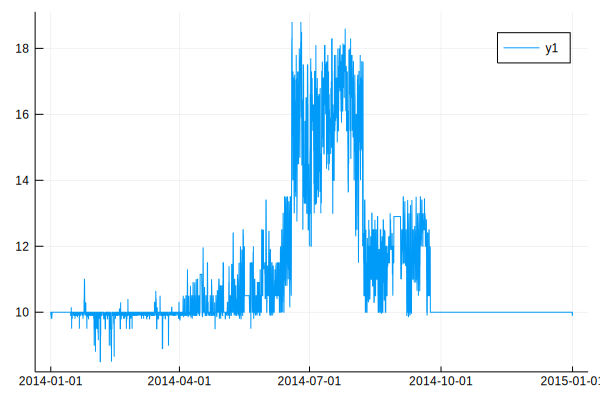

In [34]:
mpipeline2 = Pipeline(Dict(
  :transformers => [csvreader,valgator,valnner,pltr]
 )
)

fit!(mpipeline2)
transform!(mpipeline2)

### Monotonicer

In [35]:
regularfile = joinpath(dirname(pathof(TSML)),"../data/typedetection/regular.csv")
monofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/monotonic.csv")
dailymonofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/dailymonotonic.csv")

regularfilecsv = CSVDateValReader(Dict(:filename=>regularfile,:dateformat=>"dd/mm/yyyy HH:MM"))
monofilecsv = CSVDateValReader(Dict(:filename=>monofile,:dateformat=>"dd/mm/yyyy HH:MM"))
dailymonofilecsv = CSVDateValReader(Dict(:filename=>dailymonofile,:dateformat=>"dd/mm/yyyy HH:MM"))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
mono = Monotonicer(Dict())
stfier = Statifier(Dict(:processmissing=>true))
outliernicer = Outliernicer(Dict(:dateinterval=>Dates.Hour(1)));

## Plot of monotonic data

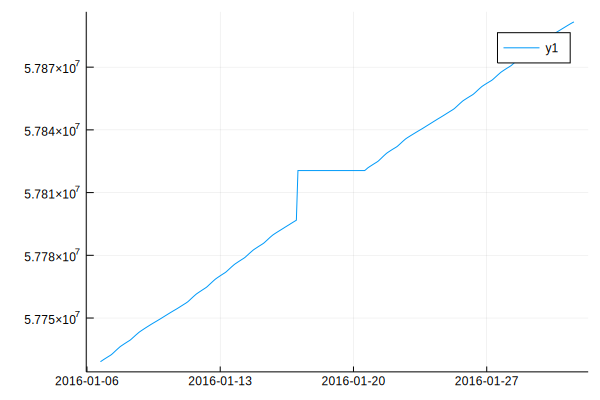

In [36]:
monopipeline = Pipeline(Dict(
  :transformers => [monofilecsv,valgator,valnner,pltr]
 )
)

fit!(monopipeline)
transform!(monopipeline)

## Plot after normalization of monotonic data

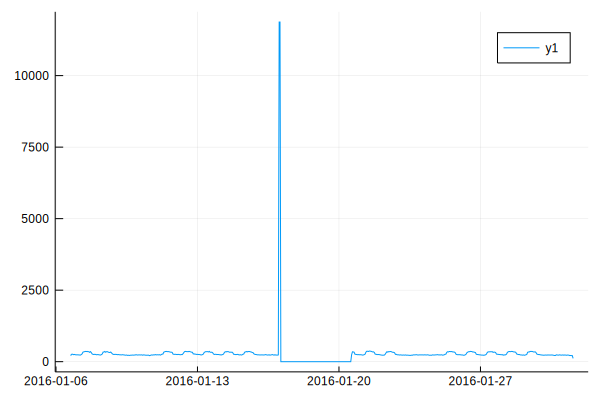

In [37]:
monopipeline = Pipeline(Dict(
  :transformers => [monofilecsv,valgator,valnner,mono,pltr]
 )
)

fit!(monopipeline)
transform!(monopipeline)

## Plot with Monotonicer and Outliernicer

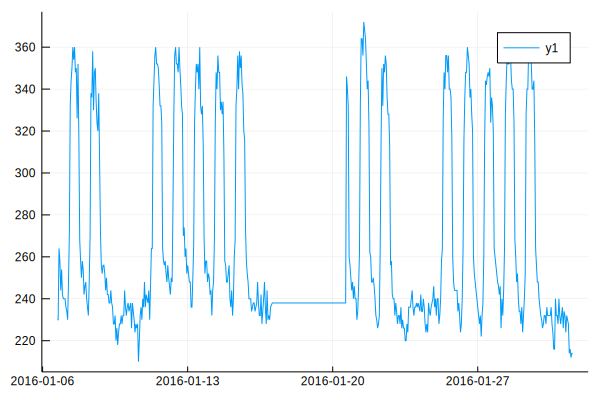

In [38]:
monopipeline = Pipeline(Dict(
  :transformers => [monofilecsv,valgator,valnner,mono,outliernicer,pltr]
 )
)

fit!(monopipeline)
transform!(monopipeline)


## Plot of daily monotonic

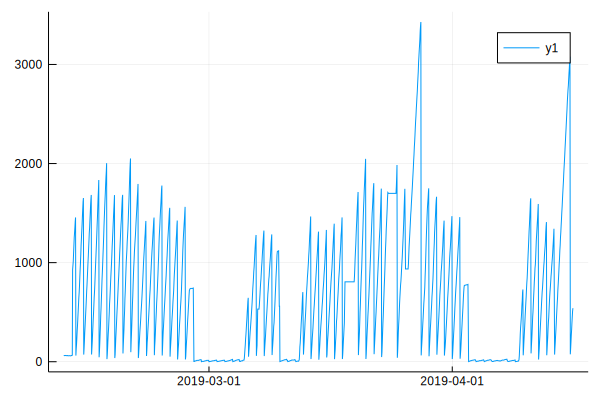

In [39]:
dailymonopipeline = Pipeline(Dict(
  :transformers => [dailymonofilecsv,valgator,valnner,pltr]
 )
)

fit!(dailymonopipeline)
transform!(dailymonopipeline)

## Plot of daily monotonic data with Monotonicer

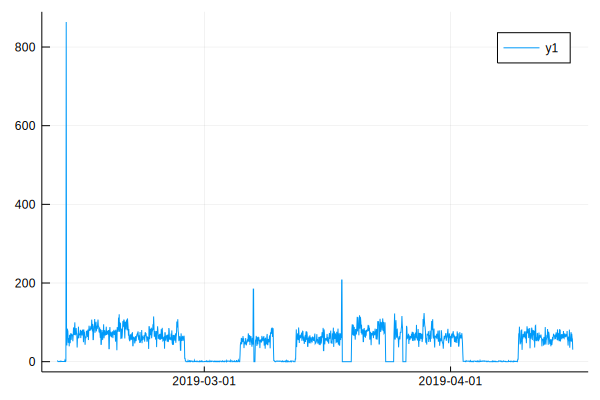

In [40]:
dailymonopipeline = Pipeline(Dict(
  :transformers => [dailymonofilecsv,valgator,valnner,mono,pltr]
 )
)
fit!(dailymonopipeline)
transform!(dailymonopipeline)

## Plot of daily monotonic with Monotonicer and Outliernicer

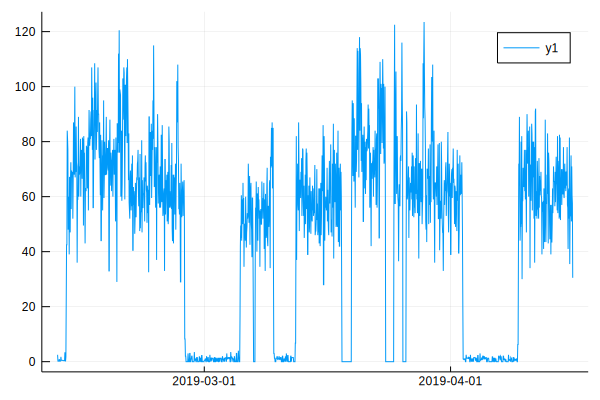

In [41]:
dailymonopipeline = Pipeline(Dict(
  :transformers => [dailymonofilecsv,valgator,valnner,mono,outliernicer,pltr]
 )
)
fit!(dailymonopipeline)
transform!(dailymonopipeline)

## Plot regular TS after monotonic normalization

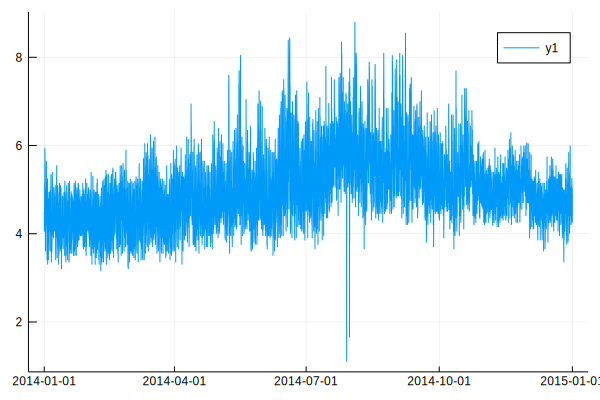

In [42]:
regpipeline = Pipeline(Dict(
  :transformers => [regularfilecsv,valgator,valnner,mono,pltr]
 )
)

fit!(regpipeline)
transform!(regpipeline)

## Plot of regular TS with outlier normalization

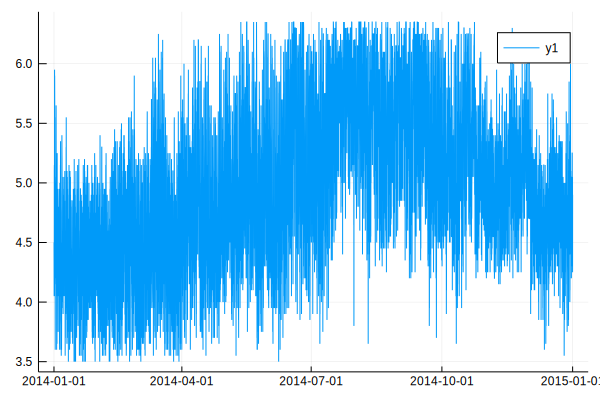

In [43]:
regpipeline = Pipeline(Dict(
  :transformers => [regularfilecsv,valgator,valnner,mono,outliernicer,pltr]
 )
)
fit!(regpipeline)
transform!(regpipeline)

## TS Discovery by automatic data type classification

In [44]:
using TSML: TSClassifier
Random.seed!(12)

trdirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/training")
tstdirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/testing")
modeldirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/model")

tscl = TSClassifier(Dict(:trdirectory=>trdirname,
           :tstdirectory=>tstdirname,
           :modeldirectory=>modeldirname,
           :feature_range => 6:20,
           :num_trees=>10)
)

fit!(tscl)
dfresults = transform!(tscl)

getting stats of AirOffTemp1.csv
getting stats of AirOffTemp2.csv
getting stats of AirOffTemp3.csv
getting stats of Energy1.csv
getting stats of Energy2.csv
getting stats of Energy3.csv
getting stats of Energy4.csv
getting stats of Energy6.csv
getting stats of Energy7.csv
getting stats of Energy8.csv
getting stats of Energy9.csv
getting stats of Pressure1.csv
skipping due to error Pressure2.csv
getting stats of Pressure3.csv
getting stats of Pressure4.csv
getting stats of Pressure6.csv
getting stats of RetTemp11.csv
getting stats of RetTemp21.csv
getting stats of RetTemp41.csv
getting stats of RetTemp51.csv
getting stats of AirOffTemp4.csv
getting stats of AirOffTemp5.csv
getting stats of Energy10.csv
getting stats of Energy5.csv
skipping due to error Pressure2.csv
getting stats of Pressure5.csv
getting stats of RetTemp31.csv
loading model from file: /Users/ppalmes/julia/TSML.jl/src/../data/realdatatsclassification/model/juliarfmodel.serialized


,fname,predtype
,String,SubStrin…
1,AirOffTemp4.csv,AirOffTemp
2,AirOffTemp5.csv,AirOffTemp
3,Energy10.csv,AirOffTemp
4,Energy5.csv,Energy
5,Pressure5.csv,Pressure
6,RetTemp31.csv,Energy


In [45]:
apredict = dfresults[:predtype]
fnames = dfresults[:fname]
myregex = r"(?<dtype>[A-Z _ - a-z]+)(?<number>\d*).(?<ext>\w+)"
mtypes=map(fnames) do fname
  mymatch=match(myregex,fname)
  mymatch[:dtype]
end

sum(mtypes .== apredict)/length(mtypes) * 100

66.66666666666666